In [2]:
import os
import sys
import pandas as pd

sys.path.append('/home/me/phd/actual-causality/subprojects/metamorphic/case-studies/lift')

In [3]:
# %load_ext autoreload
# %autoreload 2
import comparison_runner
import importlib
importlib.reload(comparison_runner)
from comparison_runner import run_comparison_study, plot_execution_time_vs_num_vars

## Execution time vs number of variables

In [ ]:
# df = run_comparison_study(num_vars_list = [0, 5, 10, 25, 50, 100, 500, 1000],
#     num_trials = 10,
#     awt_coeff = 0.8,
#     timeout = 2)

Variables:  88%|████████▊ | 7/8 [07:11<01:37, 97.90s/it]

In [6]:
df = pd.read_csv('../../execution_time_vs_num_vars.csv')

/home/me/phd/actual-causality/subprojects/metamorphic/comparison_runner.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['method_label'] = df.apply(create_method_label, axis=1)


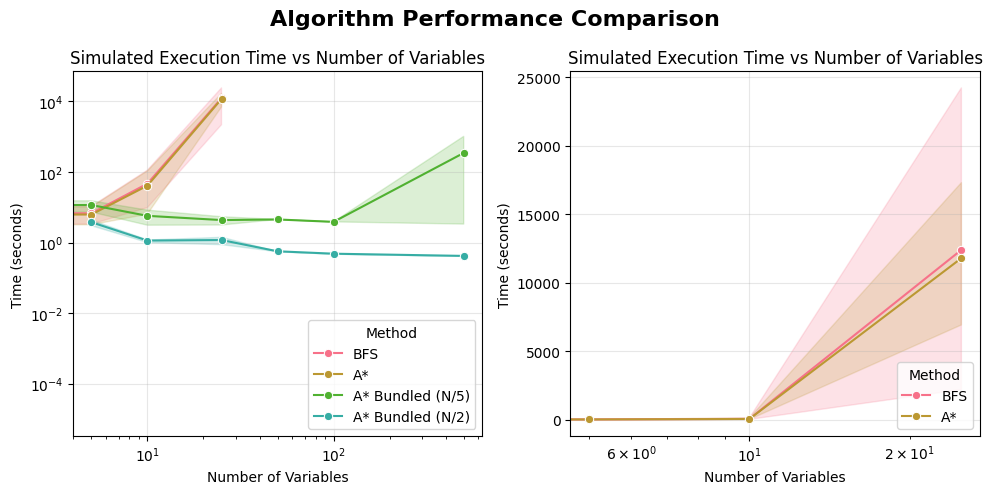

In [21]:
# %load_ext autoreload
# %autoreload 2
import comparison_runner
import importlib
importlib.reload(comparison_runner)
from comparison_runner import run_comparison_study, plot_execution_time_vs_num_vars

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
sns.set_palette("husl")

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Algorithm Performance Comparison', fontsize=16, fontweight='bold')

plot_execution_time_vs_num_vars(df, axes[0], ci=95)

plot_execution_time_vs_num_vars(df, axes[1], ci=95, methods=['bfs', 'mm'])


plt.tight_layout()
plt.show()

## Effect of awt_coeff

In [4]:
df = pd.read_csv('../../comparison_results_awt_coeff.csv')

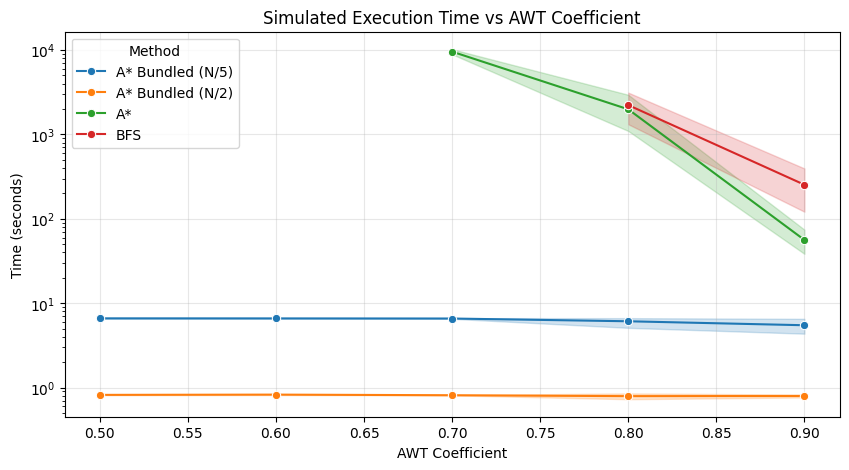

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
ax1 = axes
from comparison_runner import create_method_label
df['method_label'] = df.apply(create_method_label, axis=1)
sns.lineplot(data=df.loc[df['success'], ['awt_coeff', 'time', 'method_label']], x='awt_coeff', y='time', hue='method_label', 
                marker='o', ax=ax1, err_style='band', errorbar=('ci', 90))
ax1.set_title('Simulated Execution Time vs AWT Coefficient')
ax1.set_xlabel('AWT Coefficient')
ax1.set_ylabel('Time (seconds)')
#ax1.set_xscale('log')
ax1.set_yscale('log')
# ax1.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.legend(title='Method', loc='upper left')
ax1.grid(True, alpha=0.3)

In [8]:
# using actual simulator
# from lift_simulation import LiftSimulation, run_lift_simulation_for_lifts
# simulator_func = run_lift_simulation_for_lifts

# using a mock simulator
from mock_lift_simulation import MockLiftsSimulator
mock_simulator = MockLiftsSimulator(average_max_time=10000)
simulator_func = mock_simulator.simulate

search_space = SearchSpace(simulator_func)

In [ ]:
max_num_lifts= 10
num_experiments = 1
results = [run_exp_subject_individual(max_num_lifts, 0.5, simulator_func, search_space) for _ in tqdm(range(num_experiments))]
results

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 32.97it/s]

Initially active lifts: 6/10, initial AWT: 1666.7666666666667, aiming for: 833.3833333333333
hp done
hp mm done


[{'d_hp': np.float64(inf), 'd_hp_mm': np.float64(nan)}]

In [ ]:
draw_hists(results)

In [ ]:
draw_hists(results)

In [ ]:
draw_hists(results)

In [ ]:
results

In [ ]:
# Run experiments with N=40 and different bundle sizes
N = 40
bundle_sizes = [2, 10]
num_experiments = 5

results_bundled = []
for bundle_size in bundle_sizes:
    for _ in tqdm(range(num_experiments), desc=f"Bundle size {bundle_size}"):
        result = run_bundled_exp(N, bundle_size)
        results_bundled.append(result)

In [ ]:
# Analyze bundled results
import pandas as pd

df = pd.DataFrame(results_bundled)
print("\nSummary by bundle size:")
print(df.groupby('bundle_size')[['d_standard', 'd_bundled', 'speedup']].agg(['mean', 'std']))

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Box plot of execution times
bundle_2_standard = df[df['bundle_size'] == 2]['d_standard']
bundle_2_bundled = df[df['bundle_size'] == 2]['d_bundled']
bundle_10_standard = df[df['bundle_size'] == 10]['d_standard']
bundle_10_bundled = df[df['bundle_size'] == 10]['d_bundled']

ax1.boxplot([bundle_2_standard, bundle_2_bundled, bundle_10_standard, bundle_10_bundled],
            labels=['Standard\n(bundle=2)', 'Bundled\n(bundle=2)', 'Standard\n(bundle=10)', 'Bundled\n(bundle=10)'])
ax1.set_ylabel('Time (seconds)')
ax1.set_title('Execution Time Comparison')
ax1.grid(True, alpha=0.3)

# Bar plot of average speedup
speedup_means = df.groupby('bundle_size')['speedup'].mean()
speedup_stds = df.groupby('bundle_size')['speedup'].std()
ax2.bar(speedup_means.index.astype(str), speedup_means.values, yerr=speedup_stds.values, capsize=5)
ax2.set_xlabel('Bundle Size')
ax2.set_ylabel('Speedup Factor')
ax2.set_title('Average Speedup of Bundled vs Standard A*')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


#%% --- cell (code) ---
draw_hists(results)


#%% --- cell (code) ---
draw_hists(results)
